### Notebook for analysing nf pipeline output

#### Sequencing batch 10

### Sequencing information 
 - Analysis no.: A005
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext
 - Loaded: 12pM
 - Seq Date: 28-05-2021
 - Number of samples:96
 - Cluster Density: 927K
 - Passing Filter: 92.4/88.4
 - Output: 8.3G/7.4g
 - Fragment size: 550
 - Lib conc: 6.2
 - Cubit 0.8
 - Lib load start concentration: 4nM
 - Cyles: 502
 - PhiX: False

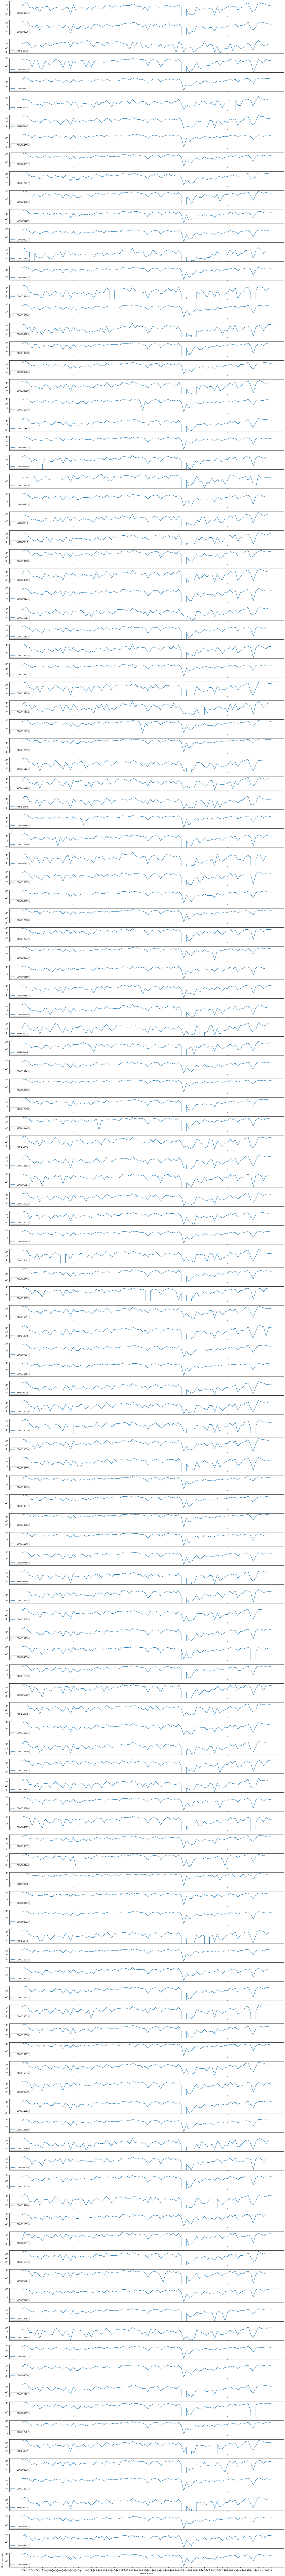

In [1]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.amplicon.regions.coverage.tsv'
base_dir = '/home/douso/2021-06-07_run9_con_2021-05-28_run8_corr/dpt'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1
fig, axs = plt.subplots(a, b, figsize=(20,180)) 

xtick = np.arange(0, 98)
xlabel = np.arange(1, 99)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    sample_df = pd.read_table(f'{base_dir}/{file}')
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='lower left')
plt.xlabel('Primer name')
plt.ylabel('Read coverage')
plt.xticks(xtick, xlabel, rotation=45)
plt.tight_layout()
plt.show()
#fig.savesample_df2fig('avg_kit_coverage2.png')


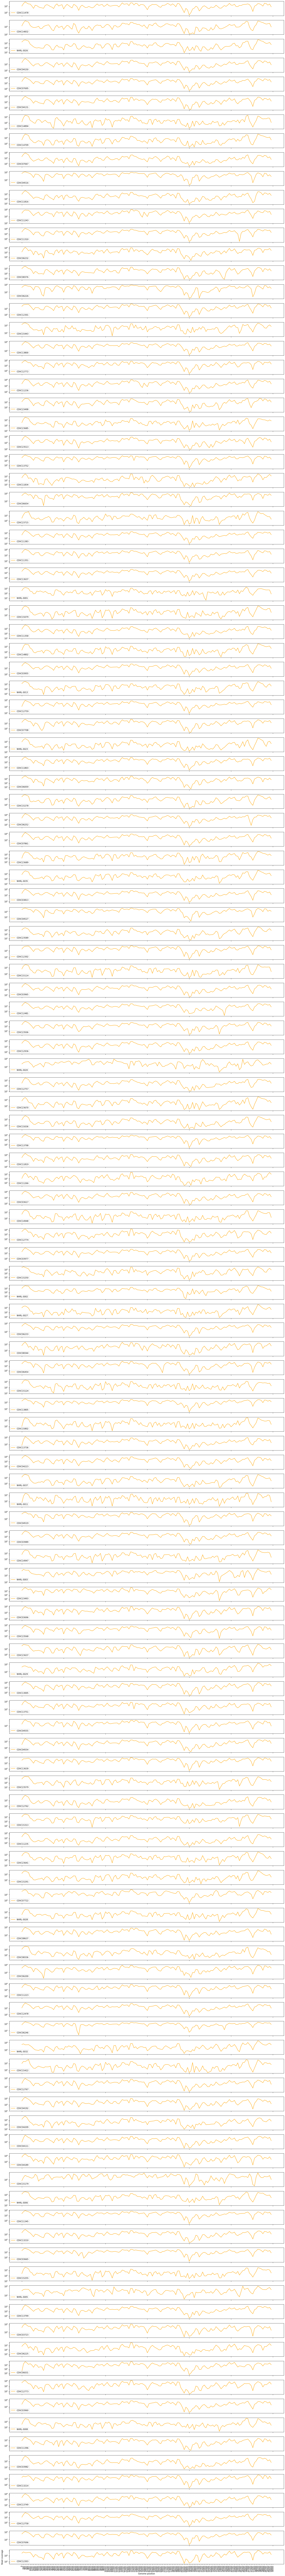

In [72]:
# plot read depths-GK
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt
base_dir = '/home/douso/2021-06-07_run9_con_2021-05-28_run8_corr/dpt'
suffix = '.genome.regions.coverage.tsv'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fig, axs = plt.subplots(a, b, figsize=(20, 180))

xtick = range(0, 30200, 200)

for file in data:
    c += 1
    sample_name = file.split('_')[0]
    try:
        df1 = pd.read_table(f'{base_dir}/{file}')
        d = df1['coverage'].to_frame()
        d.set_index(np.arange(0, 30000, 200)).plot(logy=True, ax=axs[c], sharex=True, color='orange')
        axs[c].legend([sample_name], loc='lower left')
        text = file.split('_')[1]
        plt.ylabel('Read coverage')
    except TypeError:
            print(f'no numeric data to plot for {file}')
    finally: pass
plt.xlabel('Genome position')
plt.xticks(xtick, rotation=90)
plt.tight_layout()
plt.show()
#fig.savefig('avg_kit_coverage.png')

## Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import glob

In [4]:
base_dir = '/home/douso/2021-06-07_run9_con_2021-05-28_run8_corr'
batch = 'seq10'
# dpt_dir = # ivar, samtools-depth output files
# nxt_dir = # nextclade .tsv output file
# png_dir = # pangolin .tsv output file
# var_dir = # snpEff ouput
# rmd_dir = # raw metadata - moh .xlsx spread sheet
#dpt var nxt png

### Sequencing information 
 - Analysis no.: NF-004 (batch 10)
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext
 - Seq Date: MiSeq (28-05-2021)
 - Number of samples: 96
 - Sample summ: COVCs
 - VC pipeline: nextflow-viralcon, v1.0.1

## Functions

In [5]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [6]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [7]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [8]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [9]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [10]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.set_index('S_NUM').merge(df_cts_cln.set_index('Sample_Name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'S_NUM'}))


In [11]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('S_NUM')
            .merge(df_rmdCts.set_index('S_NUM'), how='left', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'S_NUM'}))

In [12]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('_')[0]))
    return df_fnl

### Variants data

In [13]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(f'{base_dir}/var/k-per-gene_variant_anns.tsv')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: x.split('_')[0]))

In [14]:
df_var_fnl.head()

sample_name  num_vars                                             ORF1ab  \
0   COVC15079        18  E102Q, T265I, F924F, E1461E, V3261I, K3353R, L...   
1   COVC12772        15  T265I, F924F, S944L, P1096L, A2557A, P2685P, L...   
2   COVC04189        10       T265I, F924F, V1187I, P1862L, L3234L, L4715L   
3   COVC03813        11               T265I, F924F, T2154I, L4715L, V6472V   
4   COVC11834        14  F924F, T1761I, I1877T, F3444L, T4501S, L4715L,...   

   ORF1a                                   S             ORF3a  ORF3b    E  \
0    NaN        S375S, D614G, L1200L, Q1201K              Q57H    NaN  NaN   
1    NaN                     D614G, V1094V,               Q57H    NaN  NaN   
2    NaN                       D614G, S1252F              Q57H    NaN  NaN   
3    NaN                               D614G  T14I, Q57H, L65F    NaN  NaN   
4    NaN  Q52E, W152L, Y421Y, D614G, T941A,                NaN    NaN  NaN   

      M  ORF6 ORF7a  ORF7b  ORF8                   N  ORF9a  ORF9b ORF10  
0   NaN   NaN   NaN    NaN  A14T  P13S, R195K, P207T    NaN    NaN  N25N  
1  I76I  R20K  E95Q    NaN   NaN               R195K    NaN    NaN   NaN  
2   NaN   NaN   NaN    NaN   NaN               R195K    NaN    NaN   NaN  
3   NaN   NaN   NaN    NaN   NaN        R195K, H300Y    NaN    NaN   NaN  
4   NaN   NaN   NaN    NaN  T26I               S206F    NaN    NaN   NaN

### Nextclade data

In [15]:
# import Nextclade clade data
df_nxt = pd.read_table(f'{base_dir}/nxt/nxt.tsv')

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: x.split('_')[0]))
df_nxt_fnl = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)

In [16]:
df_nxt_fnl.head()

seqName clade  coverage
0  COVC03617   20C      98.6
1  COVC03665   20C      97.5
2  COVC03696   20C      98.5
3  COVC03723   20C      99.2
4  COVC03813   20C      98.6

### Pangolin data v.3.0.5 (05-06-2021) Ran: 17-06-2021

In [17]:
# import Pangolin lineage data
df_png = pd.read_csv(f'{base_dir}/png/png.csv', header=0)
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Scorpio_call']#, 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_fnl = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: x.split('_')[0]))
# df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months) if (isinstance(x, str)) else x))

In [18]:
df_png_fnl.head()

Sequence_name Lineage Scorpio_call
0     COVC03617     B.1          NaN
1     COVC03665     B.1          NaN
2     COVC03696     B.1          NaN
3     COVC03723     B.1          NaN
4     COVC03813     B.1          NaN

# Metadata

In [19]:
# import raw metadata file
import pandas as pd
mbase_dir = '/home/douso/Documents/TrendData/Results/ResultsMerged'
df_rmd_cln = pd.read_excel(f'{mbase_dir}/COVID19-results-merged-cln.xlsx')

In [20]:
df_rmd_cln.head()

S_NUM  AGE_YRS GEND     OCCU  NAT COUNT_RES S_COUNT_RES TRAV_HIST  \
0  COVC00001     35.0    F  Refugee  NaN   Garissa      Dadaab        No   
1  COVC00002     29.0    M  Refugee  NaN   Garissa      Dadaab        No   
2  COVC00003     50.0    M  Refugee  NaN   Garissa      Dadaab        No   
3  COVC00004     35.0    F   Casual  NaN   Garissa      Dadaab        No   
4  COVC00005     27.0    F  Refugee  NaN   Garissa      Dadaab        No   

  TRAV_FROM QUAR_PLACE SYMPS DT_SAM_COLL DT_SAM_RECEP    RESULT     DT_CONF  
0       NaN        NaN   NaN         NaN          NaN  Negative  02-06-2020  
1       NaN        NaN   NaN         NaN          NaN  Negative  02-06-2020  
2       NaN        NaN   NaN         NaN          NaN  Negative  02-06-2020  
3       NaN        NaN   NaN         NaN          NaN  Negative  02-06-2020  
4       NaN        NaN   NaN         NaN          NaN  Negative  02-06-2020

### Ct data

In [21]:
# import Ct data from sheet2 of the metadata file
ctbase_dir = '/home/douso/Documents/RunSheets/Cts'
df_cts = pd.read_excel(f'{ctbase_dir}/runsheet-cts.xlsx')

In [22]:
df_cts.head()

Sample_Name  Ct_Mean
0   COVC00137     37.6
1   COVC00154     35.2
2   COVC00744     34.7
3   COVC00762     36.0
4   COVC00767     34.1

### **Combining data**

#### Merge Variants and Nextclade data

In [23]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [24]:
df_varNxt.head()

sample_name  num_vars                                             ORF1ab  \
0   COVC03617        15  T265I, N430S, F924F, P1330P, A2355S, A2584V, I...   
1   COVC03665        16  T265I, N430S, F924F, P1330P, A2355S, A2584V, I...   
2   COVC03696        13  T265I, F924F, L3606F, L4715L, F4730Y, M5383T, ...   
3   COVC03723         9                               T265I, F924F, L4715L   
4   COVC03813        11               T265I, F924F, T2154I, L4715L, V6472V   

   ORF1a             S             ORF3a  ORF3b    E      M  ORF6 ORF7a  \
0    NaN         D614G       Q57H, S253S    NaN  NaN    NaN   NaN   NaN   
1    NaN  A263S, D614G       Q57H, S253S    NaN  NaN    NaN   NaN   NaN   
2    NaN         D614G        S26P, Q57H    NaN  NaN    NaN  W27L   NaN   
3    NaN         D614G        S26P, Q57H    NaN  NaN  G147G   NaN   NaN   
4    NaN         D614G  T14I, Q57H, L65F    NaN  NaN    NaN   NaN   NaN   

   ORF7b ORF8             N  ORF9a  ORF9b ORF10 clade  coverage  
0    NaN  NaN         R195K    NaN    NaN   NaN   20C      98.6  
1    NaN  NaN         R195K    NaN    NaN   NaN   20C      97.5  
2    NaN  F3S         R195K    NaN    NaN   NaN   20C      98.5  
3    NaN  F3S         R195K    NaN    NaN   NaN   20C      99.2  
4    NaN  NaN  R195K, H300Y    NaN    NaN   NaN   20C      98.6

#### Merge pango and var-nextclade data

In [25]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [26]:
df_pngVxt.head()

Sequence_name Lineage Scorpio_call  num_vars  \
0     COVC03617     B.1          NaN      15.0   
1     COVC03665     B.1          NaN      16.0   
2     COVC03696     B.1          NaN      13.0   
3     COVC03723     B.1          NaN       9.0   
4     COVC03813     B.1          NaN      11.0   

                                              ORF1ab  ORF1a             S  \
0  T265I, N430S, F924F, P1330P, A2355S, A2584V, I...    NaN         D614G   
1  T265I, N430S, F924F, P1330P, A2355S, A2584V, I...    NaN  A263S, D614G   
2  T265I, F924F, L3606F, L4715L, F4730Y, M5383T, ...    NaN         D614G   
3                               T265I, F924F, L4715L    NaN         D614G   
4               T265I, F924F, T2154I, L4715L, V6472V    NaN         D614G   

              ORF3a  ORF3b    E  ...  ORF6 ORF7a ORF7b  ORF8             N  \
0       Q57H, S253S    NaN  NaN  ...   NaN   NaN   NaN   NaN         R195K   
1       Q57H, S253S    NaN  NaN  ...   NaN   NaN   NaN   NaN         R195K   
2        S26P, Q57H    NaN  NaN  ...  W27L   NaN   NaN   F3S         R195K   
3        S26P, Q57H    NaN  NaN  ...   NaN   NaN   NaN   F3S         R195K   
4  T14I, Q57H, L65F    NaN  NaN  ...   NaN   NaN   NaN   NaN  R195K, H300Y   

  ORF9a  ORF9b  ORF10 clade coverage  
0   NaN    NaN    NaN   20C     98.6  
1   NaN    NaN    NaN   20C     97.5  
2   NaN    NaN    NaN   20C     98.5  
3   NaN    NaN    NaN   20C     99.2  
4   NaN    NaN    NaN   20C     98.6  

[5 rows x 21 columns]

In [27]:
df_pngVxt_cols = ['Sequence_name', 'Lineage', 'Scorpio call',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage']
df_pngVxt_cols_rename = ['S_NUM', 'LIN', 'SCORP_CALL',
       'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'CLADE',
       'G_COV']
df_pngVxt.columns = df_pngVxt_cols_rename

#### Merge the metadata and Cts data

In [28]:
# merge metadata with cts data
df_rmdCts = merge_rmdCts(df_rmd_cln, df_cts).rename(columns={'Ct_Mean': 'AVG_Ct'})

In [29]:
df_rmdCts.head()

S_NUM  AGE_YRS GEND     OCCU  NAT COUNT_RES S_COUNT_RES TRAV_HIST  \
0  COVC00001     35.0    F  Refugee  NaN   Garissa      Dadaab        No   
1  COVC00002     29.0    M  Refugee  NaN   Garissa      Dadaab        No   
2  COVC00003     50.0    M  Refugee  NaN   Garissa      Dadaab        No   
3  COVC00004     35.0    F   Casual  NaN   Garissa      Dadaab        No   
4  COVC00005     27.0    F  Refugee  NaN   Garissa      Dadaab        No   

  TRAV_FROM QUAR_PLACE SYMPS DT_SAM_COLL DT_SAM_RECEP    RESULT     DT_CONF  \
0       NaN        NaN   NaN         NaN          NaN  Negative  02-06-2020   
1       NaN        NaN   NaN         NaN          NaN  Negative  02-06-2020   
2       NaN        NaN   NaN         NaN          NaN  Negative  02-06-2020   
3       NaN        NaN   NaN         NaN          NaN  Negative  02-06-2020   
4       NaN        NaN   NaN         NaN          NaN  Negative  02-06-2020   

   AVG_Ct  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [30]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [31]:
df_vnpPmd.columns#shape#head()

Index(['S_NUM', 'LIN', 'SCORP_CALL', 'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a',
       'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a',
       'ORF9b', 'ORF10', 'CLADE', 'G_COV', 'AGE_YRS', 'GEND', 'OCCU', 'NAT',
       'COUNT_RES', 'S_COUNT_RES', 'TRAV_HIST', 'TRAV_FROM', 'QUAR_PLACE',
       'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 'DT_CONF', 'AVG_Ct'],
      dtype='object')

#### QC whether all samples sequenced had metadata

In [32]:
codes_fnl = set(df_vnpPmd['S_NUM'])
codes_metadata = set(df_rmdCts['S_NUM'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
{'MN908947.3'}


#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [33]:
header_MS = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'SCORP_CALL', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [34]:
header_policy = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct']

In [35]:
df_vnpPmd_fnl = df_vnpPmd[header_policy]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-M006-corr.xlsx'
                     , index=False, na_rep='N/A', float_format='%.1f'))

In [36]:
df_vnpPmd_fnl = df_vnpPmd[header_MS]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel('/home/douso/SarsGenomics/Processed/metadata-seq-MS006-corr.xlsx'
                     , index=False, na_rep='NA', float_format='%.1f'))
df_vnpPmd_fnl.head()

S_NUM  AGE_YRS GEND            OCCU    NAT COUNT_RES TRAV_HIST  \
0  COVC03617     55.0    F  None indicated  Kenya   Nairobi        No   
1  COVC03665     23.0    M  None indicated  Kenya   Nairobi        No   
2  COVC03696     24.0    M  None indicated  Kenya   Nairobi        No   
3  COVC03723     36.0    M  None indicated  Kenya   Nairobi        No   
4  COVC03813     59.0    M             NaN  Kenya   Nairobi        No   

  TRAV_FROM  QUAR_PLACE SYMPS  ...    E      M  ORF6 ORF7a  ORF7b ORF8  \
0       NaN         DSH  None  ...  NaN    NaN   NaN   NaN    NaN  NaN   
1       NaN         DSH  None  ...  NaN    NaN   NaN   NaN    NaN  NaN   
2       NaN         DSH  None  ...  NaN    NaN  W27L   NaN    NaN  F3S   
3       NaN         DSH  None  ...  NaN  G147G   NaN   NaN    NaN  F3S   
4       NaN  Hemingways    No  ...  NaN    NaN   NaN   NaN    NaN  NaN   

              N ORF9a  ORF9b  ORF10  
0         R195K   NaN    NaN    NaN  
1         R195K   NaN    NaN    NaN  
2         R195K   NaN    NaN    NaN  
3         R195K   NaN    NaN    NaN  
4  R195K, H300Y   NaN    NaN    NaN  

[5 rows x 35 columns]

### Variants of Concern or under investigation
 - N501Y (B.1.1.7): UK variant
 - N501Y, E484K, *K417N (B.1.351): SA variant
 - N501Y, E484K (P.1): Brazilian variant
 - P681R, E484Q, L452R (B.1.617.2): *Indian variant
 - F157L, V367F, Q613H, P681R (A23.1): Ugandan
 - E484K, Q677H, F888L (B.1.525): Multiple

In [37]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [38]:
df_moc.head()

Sample_ID Mut_of_Concern_(S)  \
0  NHRL-S028              A570D   
1  COVC23498       A570D, N501Y   
2  NHRL-S029       A570D, N501Y   
3  NHRL-S008              A570D   
4  COVC23641              A570D   

                                   All_Mutations_(S)  
0  D138H, Y145del, A570D, D614G, S982A, D1118H, G...  
1         Y145del, N501Y, A570D, D614G, T716I, S982A  
2  D138H, Y145del, F490S, N501Y, A570D, D614G, P6...  
3  D138H, Y145del, A570D, D614G, S982A, D1118H, G...  
4        D138H, Y145del, A570D, D614G, S982A, D1118H

### Subsample brief data

In [39]:
#reorder columns and shrink data
cols = ['S_NUM', 'G_COV', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'LIN', 'CLADE', 'SCORP_CALL', 'COUNT_RES'
        , 'GEND', 'NAT']

### Filter reporting coverage

In [40]:
df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['G_COV'] >= 80]

In [41]:
df_brief.head()

S_NUM  G_COV DT_SAM_COLL DT_SAM_RECEP  LIN CLADE SCORP_CALL COUNT_RES  \
0  COVC03617   98.6  06-07-2020          NaN  B.1   20C        NaN   Nairobi   
1  COVC03665   97.5  06-07-2020          NaN  B.1   20C        NaN   Nairobi   
2  COVC03696   98.5  06-07-2020          NaN  B.1   20C        NaN   Nairobi   
3  COVC03723   99.2  06-07-2020          NaN  B.1   20C        NaN   Nairobi   
4  COVC03813   98.6  10-07-2020          NaN  B.1   20C        NaN   Nairobi   

  GEND    NAT  
0    F  Kenya  
1    M  Kenya  
2    M  Kenya  
3    M  Kenya  
4    M  Kenya

#### Merge df_brief with df_moc

In [42]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='S_NUM', right_on='Sample_ID'))
df_brfMoc_fnl = (df_brfMoc.fillna('N/A')
                 .loc[df_brfMoc['S_NUM'] != 'Undetermined']# removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1)
                 .drop_duplicates('S_NUM', ignore_index=True))

### Policy brief report

#### Rename report columns

In [43]:
cols = ['Sequence Name', 'coverage', 'Date Collection (dd-mm-yyyy)', 'Date Received (dd-mm-yyyy)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'WHO Annotation','Sample County of Origin', 'Gender', 'Subject Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols

In [44]:
df_brfMoc_fnl.head()

Sequence Name  coverage Date Collection (dd-mm-yyyy)  \
0     COVC03617      98.6                   06-07-2020   
1     COVC03665      97.5                   06-07-2020   
2     COVC03696      98.5                   06-07-2020   
3     COVC03723      99.2                   06-07-2020   
4     COVC03813      98.6                   10-07-2020   

  Date Received (dd-mm-yyyy) Pango Lineage Annotation  \
0                        N/A                      B.1   
1                        N/A                      B.1   
2                        N/A                      B.1   
3                        N/A                      B.1   
4                        N/A                      B.1   

  Next Clade Lineage Annotation WHO Annotation Sample County of Origin Gender  \
0                           20C            N/A                 Nairobi      F   
1                           20C            N/A                 Nairobi      M   
2                           20C            N/A                 Nairobi      M   
3                           20C            N/A                 Nairobi      M   
4                           20C            N/A                 Nairobi      M   

  Subject Country of Origin MoC-S-Protein  
0                     Kenya           N/A  
1                     Kenya           N/A  
2                     Kenya           N/A  
3                     Kenya           N/A  
4                     Kenya           N/A

In [45]:
df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].isin(['COVC06200']) == True]

Sequence Name  coverage Date Collection (dd-mm-yyyy)  \
25     COVC06200      94.8                   04-08-2020   

   Date Received (dd-mm-yyyy) Pango Lineage Annotation  \
25                        N/A                      B.1   

   Next Clade Lineage Annotation WHO Annotation Sample County of Origin  \
25                           20C            N/A                 Nairobi   

   Gender Subject Country of Origin MoC-S-Protein  
25      M                     Kenya           N/A

In [46]:
def format_dates(x):
    if isinstance(x, pd.Timestamp):
        return x#x = x.strftime(format='%d-%m-%Y')
    return x
    

In [47]:
import numpy as np
df_brfMoc_fnl['Date Collection (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Collection (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [48]:
import numpy as np
df_brfMoc_fnl['Date Received (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Received (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [49]:
df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].isin(['COVC12767']) == True]

Sequence Name  coverage Date Collection (dd-mm-yyyy)  \
69     COVC12767     100.0                   2020-10-03   

   Date Received (dd-mm-yyyy) Pango Lineage Annotation  \
69                 2020-10-07                      B.1   

   Next Clade Lineage Annotation WHO Annotation Sample County of Origin  \
69                           20C            N/A                 Mombasa   

   Gender Subject Country of Origin MoC-S-Protein  
69      F                     Kenya           N/A

In [50]:
df_report_fnl = df_brfMoc_fnl

In [51]:
df_report_fnl.head()

Sequence Name  coverage Date Collection (dd-mm-yyyy)  \
0     COVC03617      98.6                   2020-07-06   
1     COVC03665      97.5                   2020-07-06   
2     COVC03696      98.5                   2020-07-06   
3     COVC03723      99.2                   2020-07-06   
4     COVC03813      98.6                   2020-07-10   

  Date Received (dd-mm-yyyy) Pango Lineage Annotation  \
0                        NaT                      B.1   
1                        NaT                      B.1   
2                        NaT                      B.1   
3                        NaT                      B.1   
4                        NaT                      B.1   

  Next Clade Lineage Annotation WHO Annotation Sample County of Origin Gender  \
0                           20C            N/A                 Nairobi      F   
1                           20C            N/A                 Nairobi      M   
2                           20C            N/A                 Nairobi      M   
3                           20C            N/A                 Nairobi      M   
4                           20C            N/A                 Nairobi      M   

  Subject Country of Origin MoC-S-Protein  
0                     Kenya           N/A  
1                     Kenya           N/A  
2                     Kenya           N/A  
3                     Kenya           N/A  
4                     Kenya           N/A

In [52]:
df_report_fnl.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-T006-corr.xlsx'
                     , index=False, na_rep='N/A', float_format='%.1f')

In [53]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

In [54]:
df_report_fnl.sort_values('Date Collection (dd-mm-yyyy)')#.head()

Sequence Name  coverage Date Collection (dd-mm-yyyy)  \
0       COVC03617      98.6                   2020-07-06   
1       COVC03665      97.5                   2020-07-06   
2       COVC03696      98.5                   2020-07-06   
3       COVC03723      99.2                   2020-07-06   
4       COVC03813      98.6                   2020-07-10   
..            ...       ...                          ...   
85      COVC13800      97.2                          NaT   
86      COVC13805      93.8                          NaT   
87      COVC14709      92.2                          NaT   
96      COVC15124      83.9                          NaT   
113     COVC23637      97.1                          NaT   

    Date Received (dd-mm-yyyy) Pango Lineage Annotation  \
0                          NaT                      B.1   
1                          NaT                      B.1   
2                          NaT                      B.1   
3                          NaT                      B.1   
4                          NaT                      B.1   
..                         ...                      ...   
85                  2020-10-13                      B.1   
86                  2020-10-13                      B.1   
87                  2020-10-19                      B.1   
96                  2020-10-22                  B.1.549   
113                 2021-03-18                  B.1.1.7   

    Next Clade Lineage Annotation        WHO Annotation  \
0                             20C                   N/A   
1                             20C                   N/A   
2                             20C                   N/A   
3                             20C                   N/A   
4                             20C                   N/A   
..                            ...                   ...   
85                            20C                   N/A   
86                            20C                   N/A   
87                            20A                   N/A   
96                            20A                   N/A   
113                   20I/501Y.V1  Alpha (B.1.1.7-like)   

    Sample County of Origin Gender Subject Country of Origin MoC-S-Protein  
0                   Nairobi      F                     Kenya           N/A  
1                   Nairobi      M                     Kenya           N/A  
2                   Nairobi      M                     Kenya           N/A  
3                   Nairobi      M                     Kenya           N/A  
4                   Nairobi      M                     Kenya           N/A  
..                      ...    ...                       ...           ...  
85                   Kiambu      F                     Kenya           N/A  
86                   Kiambu      F                     Kenya           N/A  
87                  Nairobi      M                     Kenya           N/A  
96                  Mombasa      F                     Kenya           N/A  
113                 Nairobi      M                     India  A570D, N501Y  

[136 rows x 11 columns]

In [55]:
(df_report_fnl['Sample County of Origin']
 .value_counts())

Nairobi        47
Kiambu         39
Mombasa        27
Garissa         9
Kajiado         6
Uasin gishu     3
Nakuru          2
Machakos        1
Nyeri           1
Laikipia        1
Name: Sample County of Origin, dtype: int64

In [56]:
clr_code = {'A.23': ('lime', '#00FF00'),
 'A.23.1': ('gray', '#808080'),
 'A.25': ('orangered', '#FF4500'),
 'B.1': ('cyan', '#00FFFF'),
 'B.1.1': ('chocolate', '#D2691E'),
 'B.1.1.171': ('teal', '#008080'),
 'B.1.1.406': ('slategray', '#708090'),
 'B.1.1.7': ('orange', '#FFA500'),
 'B.1.143': ('olive', '#808000'),
 'B.1.214': ('gold', '#8FBC8F'),
 'B.1.276': ('aquamarine', '#006400'),
 'B.1.336': ('tan', '#D2B48C'),
 'B.1.343': ('indigo', '#4B0082'),
 'B.1.349': ('mediumpurple', '#9370DB'),
 'B.1.351': ('blue', '#0000FF'),
 'B.1.388': ('sienna', '#A0522D'),
 'B.1.429': ('khaki', '#F0E68C'),
 'B.1.446': ('palevioletred', '#DB7093'),
 'B.1.517': ('yellow', '#FFFF00'),
 'B.1.525': ('green', '#008000'),
 'B.1.530': ('red', '#AFEEEE'),
 'B.1.549': ('brown', '#A52A2A'),
 'B.1.596.1': ('magenta', '#FF00FF'),
 'B.1.605': ('rosybrown', '#BC8F8F'),
 'B.1.617.2': ('paleturquoise', '#FF0000'),
 'TBA5': ('darkkhaki', '#BDB76B'),
 'TBA6': ('darkgreen', '#7FFFD4'),
 'TBA7': ('yellowgreen', '#9ACD32'),
 'TBA8': ('darkseagreen', '#FFD700'),
 'TBA9': ('seagreen', '#2E8B57')}#BLUES NEXT B.1.361
avail_clr = ['TBA5', 'TBA6', 'TBA7', 'TBA8', 'TBA9']

In [57]:
grpby_lins = (df_report_fnl.groupby('Pango Lineage Annotation')
        .count().sort_values('coverage', ascending=False))

In [58]:
max_count = grpby_lins['Sequence Name'].max()

In [59]:
clr_code_keys = list(clr_code.keys())

In [60]:
lins = list(grpby_lins.index)

In [61]:
len(lins)

13

In [62]:
lin_tba =  set(lins) - set(clr_code_keys)
lin_tba

{'B.1.390'}

In [63]:
import pprint
for lin, clr in zip(lin_tba, avail_clr):
    clr_code[lin] = clr_code.pop(clr)
    avail_clr.remove(clr)

In [64]:
pprint.pprint(clr_code)
pprint.pprint(avail_clr)

{'A.23': ('lime', '#00FF00'),
 'A.23.1': ('gray', '#808080'),
 'A.25': ('orangered', '#FF4500'),
 'B.1': ('cyan', '#00FFFF'),
 'B.1.1': ('chocolate', '#D2691E'),
 'B.1.1.171': ('teal', '#008080'),
 'B.1.1.406': ('slategray', '#708090'),
 'B.1.1.7': ('orange', '#FFA500'),
 'B.1.143': ('olive', '#808000'),
 'B.1.214': ('gold', '#8FBC8F'),
 'B.1.276': ('aquamarine', '#006400'),
 'B.1.336': ('tan', '#D2B48C'),
 'B.1.343': ('indigo', '#4B0082'),
 'B.1.349': ('mediumpurple', '#9370DB'),
 'B.1.351': ('blue', '#0000FF'),
 'B.1.388': ('sienna', '#A0522D'),
 'B.1.390': ('darkkhaki', '#BDB76B'),
 'B.1.429': ('khaki', '#F0E68C'),
 'B.1.446': ('palevioletred', '#DB7093'),
 'B.1.517': ('yellow', '#FFFF00'),
 'B.1.525': ('green', '#008000'),
 'B.1.530': ('red', '#AFEEEE'),
 'B.1.549': ('brown', '#A52A2A'),
 'B.1.596.1': ('magenta', '#FF00FF'),
 'B.1.605': ('rosybrown', '#BC8F8F'),
 'B.1.617.2': ('paleturquoise', '#FF0000'),
 'TBA6': ('darkgreen', '#7FFFD4'),
 'TBA7': ('yellowgreen', '#9ACD32'),
 'TBA

In [65]:
clr_code

{'A.23': ('lime', '#00FF00'),
 'A.23.1': ('gray', '#808080'),
 'A.25': ('orangered', '#FF4500'),
 'B.1': ('cyan', '#00FFFF'),
 'B.1.1': ('chocolate', '#D2691E'),
 'B.1.1.171': ('teal', '#008080'),
 'B.1.1.406': ('slategray', '#708090'),
 'B.1.1.7': ('orange', '#FFA500'),
 'B.1.143': ('olive', '#808000'),
 'B.1.214': ('gold', '#8FBC8F'),
 'B.1.276': ('aquamarine', '#006400'),
 'B.1.336': ('tan', '#D2B48C'),
 'B.1.343': ('indigo', '#4B0082'),
 'B.1.349': ('mediumpurple', '#9370DB'),
 'B.1.351': ('blue', '#0000FF'),
 'B.1.388': ('sienna', '#A0522D'),
 'B.1.429': ('khaki', '#F0E68C'),
 'B.1.446': ('palevioletred', '#DB7093'),
 'B.1.517': ('yellow', '#FFFF00'),
 'B.1.525': ('green', '#008000'),
 'B.1.530': ('red', '#AFEEEE'),
 'B.1.549': ('brown', '#A52A2A'),
 'B.1.596.1': ('magenta', '#FF00FF'),
 'B.1.605': ('rosybrown', '#BC8F8F'),
 'B.1.617.2': ('paleturquoise', '#FF0000'),
 'TBA6': ('darkgreen', '#7FFFD4'),
 'TBA7': ('yellowgreen', '#9ACD32'),
 'TBA8': ('darkseagreen', '#FFD700'),
 'TBA

In [66]:
df_report_fnl['Pango Lineage Annotation'].unique()

array(['B.1', 'B.1.1', 'B.1.276', 'B.1.549', 'A.25', 'B.1.390', 'A.23.1',
       'B.1.214', 'B.1.530', 'B.1.1.7', 'B.1.351', 'B.1.617.2', 'B.1.429'],
      dtype=object)

In [67]:
lins = list(grpby_lins.index)

In [68]:
lins

['B.1',
 'B.1.1.7',
 'B.1.549',
 'B.1.276',
 'B.1.351',
 'B.1.1',
 'B.1.617.2',
 'A.23.1',
 'A.25',
 'B.1.214',
 'B.1.390',
 'B.1.429',
 'B.1.530']

In [69]:
xlabels = ['B.1',
 'B.1.1.7(Alpha)',
 'B.1.549',
 'B.1.276',
 'B.1.351(Beta)',
 'B.1.1',
 'B.1.617.2(Delta)',
 'A.23.1',
 'A.25',
 'B.1.214',
 'B.1.390',
 'B.1.429',
 'B.1.530']

In [70]:
(df_report_fnl['Pango Lineage Annotation']
 .value_counts())

B.1          83
B.1.1.7      23
B.1.549      14
B.1.276       3
B.1.351       3
B.1.1         2
B.1.617.2     2
B.1.214       1
A.23.1        1
B.1.530       1
A.25          1
B.1.390       1
B.1.429       1
Name: Pango Lineage Annotation, dtype: int64

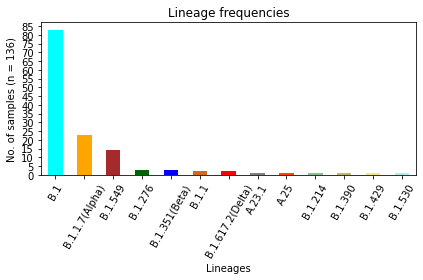

In [73]:
import math
# plot lineage frequencies
colors = [clr_code[lin][1] for lin in lins]
n = df_report_fnl['Pango Lineage Annotation'].count()
yticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
(df_report_fnl['Pango Lineage Annotation']
 .value_counts()
 .plot(kind='bar', ax=ax, color=colors))
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.yticks(yticks)
plt.xticks(ticks=range(len(lins)), rotation=60, labels=xlabels)
plt.ylabel(f'No. of samples (n = {n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P006-corr.png', dpi=300.0)
plt.show()